# Bert Model 다운로드

In [1]:
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

--2023-07-25 23:45:39--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 142.251.172.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip.1’

multi_cased_L-12_H- 100%[===================>] 632.19M  62.0MB/s    in 5.8s    

2023-07-25 23:45:45 (109 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip.1’ saved [662903077/662903077]



In [2]:
import os

# 'bert'라는 이름의 디렉토리 만들기
if "bert" not in os.listdir():
    os.makedirs("bert")
else:
    pass

import zipfile
import shutil

# 만들어 둔 'bert' 디렉토리에 zip파일 압축해제
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')

# zip파일 닫기
bert_zip.close()

# 데이터셋 다운로드

### KorQuAD1.0 한국어 Q&A

In [3]:
!wget https://raw.githubusercontent.com/monologg/KoBERT-KorQuAD/master/data/KorQuAD_v1.0_dev.json
!wget https://raw.githubusercontent.com/monologg/KoBERT-KorQuAD/master/data/KorQuAD_v1.0_train.json

--2023-07-25 23:46:01--  https://raw.githubusercontent.com/monologg/KoBERT-KorQuAD/master/data/KorQuAD_v1.0_dev.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3881058 (3.7M) [text/plain]
Saving to: ‘KorQuAD_v1.0_dev.json.1’

KorQuAD_v1.0_dev.js 100%[===================>]   3.70M  --.-KB/s    in 0.1s    

2023-07-25 23:46:02 (38.4 MB/s) - ‘KorQuAD_v1.0_dev.json.1’ saved [3881058/3881058]

--2023-07-25 23:46:02--  https://raw.githubusercontent.com/monologg/KoBERT-KorQuAD/master/data/KorQuAD_v1.0_train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [4]:
# 현재 위치 폴더 내의 파일 list보기
import os
os.listdir()

['.config',
 'KorQuAD_v1.0_dev.json.1',
 'KorQuAD_v1.0_train.json.1',
 'KorQuAD_v1.0_train.json',
 'multi_cased_L-12_H-768_A-12.zip.1',
 'bert',
 'gdrive',
 'KorQuAD_v1.0_dev.json',
 'multi_cased_L-12_H-768_A-12.zip',
 'sample_data']

In [5]:
# Google Drive와 Colab 연동
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
path = "gdrive/My Drive/dp_project"

# 예측 모델을 만들기 위한 필요 라이브러리 호출

In [7]:
import warnings
warnings.filterwarnings(action='ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import pandas as pd
import numpy as np
import re
import pickle
from keras import backend as K
from keras import Input, Model
from keras import optimizers

from keras.layers import Layer

import codecs
from tqdm import tqdm
import shutil
import json

# Check if you are running on a TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    tpu = None

# If not using TPU, use the default strategy (CPU/GPU)
if tpu is None:
    strategy = tf.distribute.TPUStrategy()

print("Number of replicas in sync: ", strategy.num_replicas_in_sync)


Running on TPU  grpc://10.11.203.114:8470
Number of replicas in sync:  8


In [8]:
# # Colab의 기본 Tensorflow의 버전은 2.x이기 때문에 버전 지정
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# import pandas as pd # 데이터프레임 형식을 사용하기 위한 라이브러리
# import numpy as np
# import re
# import pickle # 학습한 모델을 저장하거나, 열 떄 사용

# import keras as keras
# from keras.models import load_model # 모델 불러오기
# from keras import backend as K
# from keras import Input, Model
# from keras import optimizers

# from keras import backend as K
# from keras.layers import Layer

# import codecs
# from tqdm import tqdm # 학습하는 동안 얼마나 학습했는지 눈으로 수치화해서 bar로 보여주는 라이브러리
# import shutil
# import json # 데이터 형식이 json 형식이므로 json 처리에 필요한 라이브러리

In [9]:
# import warnings
# warnings.filterwarnings(action='ignore')
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# tf.logging.set_verbosity(tf.logging.ERROR)

## Bert 활용을 쉽게하기 위한 keras-bert 설치
## Adam optimizer 수정판 keras-radam 모듈 Import

In [10]:
!pip install keras-bert
!pip install keras-rectified-adam

# keras-bert 라이브러리에서 Bert Model 활용에 필요한 모듈 Import

In [11]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

KoQuAD JSON 파일을 PANDAS DATAFRAME으로 변환

In [12]:
def korquad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    if verbose:
        print("Reading the json file")
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])

    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [13]:
train = korquad_json_to_dataframe_train(path+"/dataset/KorQuAD_v1.0_train.json")

Reading the json file
processing...
shape of the dataframe is (60407, 6)
Done


In [14]:
train_A = train.iloc[:30204]

In [15]:
# train_A

In [16]:
train_B = train.iloc[30204:].reset_index().drop(columns='level_0', axis=1)

In [17]:
# train_B

bert 훈련을 위한 사전 설정

In [18]:
# SEQ_LEN  - 문장의 최대 길이 기준
# SEQ_LEN보다 문장이 작을 경우 남은 부분은 0으로 채워짐
# SEQ_LEN보다 문장이 길경우 SEQ_LEN을 초과하는 부분이 잘려짐
SEQ_LEN = 384
BATCH_SIZE = 10
EPOCHS =1
LR = 3E-5

pretrained_path = "bert/multi_cased_L-12_H-768_A-12"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = 'context'
QUESTION_COLUMN = 'question'
TEXT = 'text'

vocab.txt에 있는 단어에 index를 추가해주는 token_dick라는 딕셔너리 생성

분석할 문장이 토큰화 → 인덱스로 변경 → Bert 신경망에 input으로 들어감

In [19]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
            token = token.replace("_", "")
            token = '##' + token
        token_dict[token] = len(token_dict)

Tokenizer 재정의

 - BERT 토큰화는 단어를 분리하는 토큰화 방식(wordpiece 방식)
 - 한국어를 형태소로 꼭 변환해야할 문제를 해결.
 - 의미가 있는 단어는 밀접하게 연관이 되게하는 장점
 - 단어의 첫 시작은 ##가 붙지 않지만, 단어에 포함되면서 단어의 시작이 아닌 부분에는 ##가 붙는 것이 특징
 - 기존 Tokenizer class를 상속 받아서 재정의 해주어야 완전자모분리 현상이 발생하지 않음

In [20]:
class inherit_Tokenizer(Tokenizer):
    def _tokenize(self, text):
        if not self._cased:
            text = text
            text = text.lower()
        spaced = ''

        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' '+ ch +' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [21]:
tokenizer = inherit_Tokenizer(token_dict)

Token화 확인
 - 문장 앞에 [CLS] 문자 위치
 - 문장 뒤에 [SEP] 문자 위치

In [22]:
print(tokenizer.tokenize('한국어 토큰화.'), tokenizer.tokenize('잘되니?'))

['[CLS]', '한국', '##어', '토', '##큰', '##화', '.', '[SEP]'] ['[CLS]', '잘', '##되', '##니', '?', '[SEP]']


In [23]:
token_dict

{'[PAD]': 0,
 '[unused1]': 1,
 '[unused2]': 2,
 '[unused3]': 3,
 '[unused4]': 4,
 '[unused5]': 5,
 '[unused6]': 6,
 '[unused7]': 7,
 '[unused8]': 8,
 '[unused9]': 9,
 '[unused10]': 10,
 '[unused11]': 11,
 '[unused12]': 12,
 '[unused13]': 13,
 '[unused14]': 14,
 '[unused15]': 15,
 '[unused16]': 16,
 '[unused17]': 17,
 '[unused18]': 18,
 '[unused19]': 19,
 '[unused20]': 20,
 '[unused21]': 21,
 '[unused22]': 22,
 '[unused23]': 23,
 '[unused24]': 24,
 '[unused25]': 25,
 '[unused26]': 26,
 '[unused27]': 27,
 '[unused28]': 28,
 '[unused29]': 29,
 '[unused30]': 30,
 '[unused31]': 31,
 '[unused32]': 32,
 '[unused33]': 33,
 '[unused34]': 34,
 '[unused35]': 35,
 '[unused36]': 36,
 '[unused37]': 37,
 '[unused38]': 38,
 '[unused39]': 39,
 '[unused40]': 40,
 '[unused41]': 41,
 '[unused42]': 42,
 '[unused43]': 43,
 '[unused44]': 44,
 '[unused45]': 45,
 '[unused46]': 46,
 '[unused47]': 47,
 '[unused48]': 48,
 '[unused49]': 49,
 '[unused50]': 50,
 '[unused51]': 51,
 '[unused52]': 52,
 '[unused53]': 53

In [24]:
reserve_token_dict = {v: k for k, v in token_dict.items()}

In [25]:
reserve_token_dict

{0: '[PAD]',
 1: '[unused1]',
 2: '[unused2]',
 3: '[unused3]',
 4: '[unused4]',
 5: '[unused5]',
 6: '[unused6]',
 7: '[unused7]',
 8: '[unused8]',
 9: '[unused9]',
 10: '[unused10]',
 11: '[unused11]',
 12: '[unused12]',
 13: '[unused13]',
 14: '[unused14]',
 15: '[unused15]',
 16: '[unused16]',
 17: '[unused17]',
 18: '[unused18]',
 19: '[unused19]',
 20: '[unused20]',
 21: '[unused21]',
 22: '[unused22]',
 23: '[unused23]',
 24: '[unused24]',
 25: '[unused25]',
 26: '[unused26]',
 27: '[unused27]',
 28: '[unused28]',
 29: '[unused29]',
 30: '[unused30]',
 31: '[unused31]',
 32: '[unused32]',
 33: '[unused33]',
 34: '[unused34]',
 35: '[unused35]',
 36: '[unused36]',
 37: '[unused37]',
 38: '[unused38]',
 39: '[unused39]',
 40: '[unused40]',
 41: '[unused41]',
 42: '[unused42]',
 43: '[unused43]',
 44: '[unused44]',
 45: '[unused45]',
 46: '[unused46]',
 47: '[unused47]',
 48: '[unused48]',
 49: '[unused49]',
 50: '[unused50]',
 51: '[unused51]',
 52: '[unused52]',
 53: '[unused53]'

- Bert에 Input으로 들어가는 Token은 문장을 Tokenizing한 후, 인덱스 번호를 매긴 것
- segment는 문장 2개 이상 있을 경우, 앞의 문장과 뒤의 문장을 구분하는 것
- Position Embedding은 단순히 단어의 위치를 말함

In [26]:
question = train['question'][0]
context = train['context'][0]
text = train['text'][0]

In [27]:
question

'바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'

In [28]:
context

'1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.'

In [29]:
text

'교향곡'

In [30]:
print(tokenizer.tokenize(question, context))

['[CLS]', '바', '##그', '##너', '##는', '괴', '##테', '##의', '파', '##우스', '##트를', '읽', '##고', '무', '##엇', '##을', '쓰', '##고', '##자', '했', '##는', '##가', '?', '[SEP]', '1839', '##년', '바', '##그', '##너', '##는', '괴', '##테', '##의', '파', '##우스', '##트', '##을', '처음', '읽', '##고', '그', '내', '##용', '##에', '마', '##음', '##이', '끌', '##려', '이를', '소', '##재', '##로', '해', '##서', '하나의', '교', '##향', '##곡', '##을', '쓰', '##려', '##는', '뜻', '##을', '갖', '##는다', '.', '이', '시', '##기', '바', '##그', '##너', '##는', '1838', '##년에', '빛', '독', '##촉', '##으로', '산', '##전', '##수', '##전을', '다', '걲', '##은', '상', '##황', '##이', '##라', '좌', '##절', '##과', '실', '##망', '##에', '가', '##득', '##했으며', '메', '##피', '##스', '##토', '##펠', '##레스', '##를', '만', '##나는', '파', '##우스', '##트', '##의', '심', '##경', '##에', '공', '##감', '##했다', '##고', '한다', '.', '또한', '파', '##리에', '##서', '아', '##브', '##네', '##크', '##의', '지', '##휘', '##로', '파', '##리', '음악', '##원', '관', '##현', '##악', '##단', '##이', '연', '##주', '##하는', '베', '##토', '##벤', '##의', '교', '##향', '##곡', '9'

In [31]:
print(tokenizer.tokenize(text))

['[CLS]', '교', '##향', '##곡', '[SEP]']


In [32]:
def convert_data(data_df):
    global tokenizer
    indices, segments, target_start, target_end = [], [], [], []
    for i in tqdm(range(len(data_df))):

        ids, segment = tokenizer.encode(data_df[QUESTION_COLUMN][i], data_df[DATA_COLUMN][i], max_len=SEQ_LEN)


        text = tokenizer.encode(data_df[TEXT][i])[0]

        text_slide_len = len(text[1:-1])
        for i in range(1,len(ids)-text_slide_len-1):
            exist_flag = 0
            if text[1:-1] == ids[i:i+text_slide_len]:
              ans_start = i
              ans_end = i + text_slide_len - 1
              exist_flag = 1
              break

        if exist_flag == 0:
            ans_start = SEQ_LEN
            ans_end = SEQ_LEN

        indices.append(ids)
        segments.append(segment)

        target_start.append(ans_start)
        target_end.append(ans_end)

    indices_x = np.array(indices)
    segments = np.array(segments)
    target_start = np.array(target_start)
    target_end = np.array(target_end)

    del_list = np.where(target_start!=SEQ_LEN)[0]

    indices_x = indices_x[del_list]
    segments = segments[del_list]
    target_start = target_start[del_list]
    target_end = target_end[del_list]

    train_y_0 = tf.keras.utils.to_categorical(target_start, num_classes=SEQ_LEN, dtype='int64')
    train_y_1 = tf.keras.utils.to_categorical(target_end, num_classes=SEQ_LEN, dtype='int64')
    train_y_cat = [train_y_0, train_y_1]

    return [indices_x, segments], train_y_cat

def load_data(pandas_dataframe):
    data_df = pandas_dataframe

    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)

    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [33]:
train_A_x, train_A_y = load_data(train_A)

100%|██████████| 30204/30204 [01:47<00:00, 279.78it/s]


In [34]:
train_A_x[0]

array([[   101,   9318,  78136, ...,  12178,   9011,    102],
       [   101,   9318,  78136, ...,   9011, 118783,    102],
       [   101,   9318,  78136, ...,   9011, 118783,    102],
       ...,
       [   101,   9665,  83616, ...,      0,      0,      0],
       [   101,   9665,  83616, ...,      0,      0,      0],
       [   101,   9665,  83616, ...,      0,      0,      0]])

In [35]:
train_A.shape

(30204, 6)

In [36]:
train_A_x[0].shape

(25374, 384)

In [37]:
train_B_x, train_B_y = load_data(train_B)

100%|██████████| 30203/30203 [01:13<00:00, 409.77it/s]


In [38]:
train_B_x[0]

array([[   101,   9665,  83616, ...,      0,      0,      0],
       [   101,   9665,  83616, ...,      0,      0,      0],
       [   101,   9638,  22333, ...,      0,      0,      0],
       ...,
       [   101,   9319, 119351, ...,      0,      0,      0],
       [   101,    182,  10162, ...,      0,      0,      0],
       [   101,  19145,  17289, ...,      0,      0,      0]])

In [39]:
train_B.shape

(30203, 6)

In [40]:
train_B_x[0].shape

(25235, 384)

In [41]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=False,
    trainable=True,
    seq_len = SEQ_LEN
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Token (InputLayer)       [(None, 384)]        0           []                               
                                                                                                  
 Input-Segment (InputLayer)     [(None, 384)]        0           []                               
                                                                                                  
 Embedding-Token (TokenEmbeddin  [(None, 384, 768),  91812096    ['Input-Token[0][0]']            
 g)                              (119547, 768)]                                                   
                                                                                                  
 Embedding-Segment (Embedding)  (None, 384, 768)     1536        ['Input-Segment[0][0]']    

In [42]:
class NonMasking(Layer):
    def __init__(self, **kwargs):
        self.supports_masking = True
        super(NonMasking, self).__init__(**kwargs)

    def build(self, input_shape):
        input_shape = input_shape

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        return x

    def get_out_shape_for(self, input_shape):
        return input_shape

In [43]:
class MyLayer_Start(Layer):

    def __init__(self,seq_len, **kwargs):

        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_Start, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W = self.add_weight(name='kernel',
                                 shape=(input_shape[2],2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_Start, self).build(input_shape)

    def call(self, x):

        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)

        x = K.permute_dimensions(x, (2,0,1))

        self.start_logits, self.end_logits = x[0], x[1]

        self.start_logits = K.softmax(self.start_logits, axis=-1)

        return self.start_logits

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)

In [44]:
class MyLayer_End(Layer):
  def __init__(self,seq_len, **kwargs):

        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_End, self).__init__(**kwargs)

  def build(self, input_shape):

        self.W = self.add_weight(name='kernel',
                                 shape=(input_shape[2], 2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_End, self).build(input_shape)


  def call(self, x):


        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)
        x = K.permute_dimensions(x, (2,0,1))

        self.start_logits, self.end_logits = x[0], x[1]

        self.end_logits = K.softmax(self.end_logits, axis=-1)

        return self.end_logits

  def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)

In [45]:
from keras.layers import dot, concatenate
from keras import metrics

def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.output
  x = NonMasking()(dense)
  outputs_start = MyLayer_Start(SEQ_LEN)(x)
  outputs_end = MyLayer_End(SEQ_LEN)(x)
  bert_model = tf.keras.models.Model(inputs, [outputs_start, outputs_end])
  bert_model.compile(
      optimizer= tf.keras.optimizers.Adam(learning_rate=LR),
      loss='categorical_crossentropy',
      metrics=['accuracy'])

  return bert_model

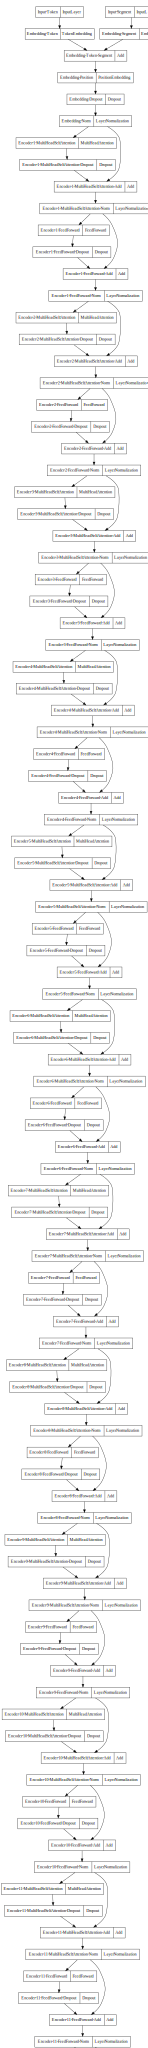

In [46]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

In [51]:
import tensorflow as tf

# Assuming get_bert_finetuning_model function is defined to create the BERT model
bert_model = get_bert_finetuning_model(model)
bert_model.summary()

# Assuming you have defined train_x and train_y with your training data and labels
history = bert_model.fit(train_A_x, train_A_y, batch_size=10, validation_split=0.05, shuffle=False, verbose=1)
history_additional = bert_model.fit(train_B_x, train_B_y, batch_size=10, validation_split=0.05, shuffle=True, verbose=1)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Token (InputLayer)       [(None, 384)]        0           []                               
                                                                                                  
 Input-Segment (InputLayer)     [(None, 384)]        0           []                               
                                                                                                  
 Embedding-Token (TokenEmbeddin  [(None, 384, 768),  91812096    ['Input-Token[0][0]']            
 g)                              (119547, 768)]                                                   
                                                                                                  
 Embedding-Segment (Embedding)  (None, 384, 768)     1536        ['Input-Segment[0][0]']    

In [52]:
path = "gdrive/My Drive/dp_project/model"

In [53]:
bert_model.save_weights(path+"/squad_wordpiece2.h5")

In [54]:
bert_model.save(path+'/KorQuad.h5')

In [56]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path+"/squad_wordpiece2.h5")

In [57]:
def convert_pred_data(question, doc):
    global tokenizer
    indices, segments = [], []
    ids, segment = tokenizer.encode(question, doc, max_len=SEQ_LEN)
    indices.append(ids)
    segments.append(segment)
    indices_x = np.array(indices)
    segments = np.array(segments)
    return [indices_x, segments]

def load_pred_data(question, doc):
    data_x = convert_pred_data(question, doc)
    return data_x

In [64]:
def predict_letter(question, doc):

  test_input = load_pred_data(question, doc)
  test_start, test_end = bert_model.predict(test_input)

  indexes = tokenizer.encode(question, doc, max_len=SEQ_LEN)[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]
  print("Question : ", question)

  print("-"*50)
  print("Context : ", end = " ")

  def split_text(text, n):
    for line in text.splitlines():
        while len(line) > n:
           x, line = line[:n], line[n:]
           yield x
        yield line



  for line in split_text(doc, 150):
    print(line)

  print("-"*50)
  print("ANSWER : ", end = " ")
  print("\n")
  sentences = []

  for i in range(start, end+1):
    token_based_word = reserve_token_dict[indexes[i]]
    sentences.append(token_based_word)
    print(token_based_word, end= " ")

  print("\n")
  print("Untokenized Answer : ", end = "")
  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
    else:
      w = " " + w

    print(w, end="")
  print("")

In [65]:
def squad_json_to_dataframe_dev(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])

    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [66]:
input_file_path = 'KorQuAD_v1.0_dev.json'
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev = squad_json_to_dataframe_dev(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...
shape of the dataframe is (5774, 5)
Done


In [67]:
dev

,id,question,context,answers,c_id
0,6548850-0-0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '1989년 2월 15일', 'answer_start': 0}]",0
1,6548850-0-1,1989년 6월 30일 평양축전에 대표로 파견 된 인물은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '임수경', 'answer_start': 125}]",0
2,6548853-0-0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '1989년', 'answer_start': 0}]",0
3,6548853-0-1,임종석을 검거한 장소는 경희대 내 어디인가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '학생회관 건물 계단', 'answer_start': 365}]",0
4,6548853-0-2,임종석이 조사를 받은 뒤 인계된 곳은 어딘가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '서울지방경찰청 공안분실', 'answer_start': 457}]",0
...,...,...,...,...,...
5769,6511152-4-0,중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생한 년도는?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '2016년', 'answer_start': 0}]",959
5770,6511152-4-1,갤럭시 S7엣지를 만든 회사는?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '삼성전자', 'answer_start': 83}]",959
5771,6511152-4-2,2016년 9월 4일 갤럭시 S7엣지가 폭발한 사건이 발생한 지역은?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '중동 지역', 'answer_start': 12}]",959
5772,6535617-4-0,갤럭시 노트 7은 출시 며칠만에 기기 결함으로 터지기 시작하였나?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '18일', 'answer_start': 286}]",959


In [68]:
import random
for i in random.sample(range(1000),1000):
  doc = dev['context'][i]
  question = dev['question'][i]
  answers = dev['answers'][i]
  predict_letter(question, doc)
  print("")
  print("real answer : ", answers)
  print("")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Context :  칭짱(青藏)고원이라고도 불리는 티베트 고원은 동아시아에 위치한 넓고 높은 고원이다. 티베트자치구역과 중국 칭하이성(青海省), 그리고 인도 카슈미르에 걸쳐 있는 티베트 고원은 남북 1000km, 동서 2500km에 뻗어 있으며, 그 평균 높이는 4500 미터가 넘는다. 
'세계의 지붕'으로 불릴 만큼 세계에서 가장 높고 크며 면적은 약 250만 평방 킬로미터나 된다. 이 고원은 인도-호주 플레이트와 유라시아 플레이트가 신생대에 충돌하며 생성되었으며 그 과정은 지금도 진행되고 있다. 이 고원은 산맥과 소금 호수가 분포한 고원의 건조 스텝
지대를 형성하고 있다. 한 해 평균 강수량은 100mm에서 300mm로, 강수량의 대부분은 우박을 이룬다. 유목민들은 고원의 남부 및 동부 경계의 한 해 6개월가량 서리가 내리는 목초지에서 유목 생활을 유지하고 있다. 고원의 북부과 북서부에 위치한 외딴 커커시리(Kek
exili) 지역에 이르기까지 북서부로 갈수록, 고원의 고도가 높아지며, 기온이 떨어지며, 토질이 척박해짐을 알 수 있다. 이 지역 평균 고도는 5,000미터(16,500피트)가 넘으며, 대기 속 산소량은 해수면 산소량의 60%에 맞먹으며, 한 해 평균 영하 4'C의 
기온을 나타내며, 최저 기온은 영하 40'C까지 떨어진다.
--------------------------------------------------
ANSWER :  

칭 ##짱 

Untokenized Answer :  칭짱

real answer :  [{'text': '칭짱(青藏)고원', 'answer_start': 0}]

1/1 [==============================] - 1s 551ms/step
Question :  금강산 관광개발 의정서의 체결 연도는?
--------------------------------------------------
Context :  현대그룹 창업자 정주영

In [71]:
doc = '''같은 해 5월 11일의 하코다테 총공격(하코다테 해전)에서 벤텐 다이바와 기관 고장으로 움직일 수 없는 떠 있는 포대가 된 가이텐마루의 원호를 받으며 신정부 군 함대와 응전을 벌인다. 새 정부 군함 초요마루의 화약고에 작렬탄을 명중시켜 초요마루는 대폭발을 일으켜 2분만
에 굉침된다. 이것은 구 막부군의 사기를 단번에 향상시켰다. 그후 반류마루는 신정부군의 집중 포화를 맞았다. 응전을 계속했지만, 오후가 되면서 탄약이 완전히 소진되었기 때문에 부득이 퇴함을 결정했고, 벤텐 다이바 아래까지 물러나 얕은 물에 좌초시켰다. 승무원은 기관을
파괴 후 (함장 마쓰오카 바키치가 ‘나중에 사용할 수도 있을 것’이라고 방화를 금지했기 때문에 불태우지는 않음), 벤텐 다이바 근처에 도착, 적지 한 가운데를 가로질러 오다이바로 들어갔다. 이날 신정부군의 손에 반류마루는 방화를 당했지만, 화재는 돛대를 태우는 정도에
그쳤고, 선체는 대부분 타지 않았으며, 그 중간 돛대가 부러지면서 균형을 잃고 전복되면서 진화되었다.
'''
question = "반류마루는 누구에 의해 집중 포화를 맞았을까?"

predict_letter(question, doc)

1/1 [==============================] - 1s 559ms/step
Question :  반류마루는 누구에 의해 집중 포화를 맞았을까?
--------------------------------------------------
Context :  같은 해 5월 11일의 하코다테 총공격(하코다테 해전)에서 벤텐 다이바와 기관 고장으로 움직일 수 없는 떠 있는 포대가 된 가이텐마루의 원호를 받으며 신정부 군 함대와 응전을 벌인다. 새 정부 군함 초요마루의 화약고에 작렬탄을 명중시켜 초요마루는 대폭발을 일으켜 2분만
에 굉침된다. 이것은 구 막부군의 사기를 단번에 향상시켰다. 그후 반류마루는 신정부군의 집중 포화를 맞았다. 응전을 계속했지만, 오후가 되면서 탄약이 완전히 소진되었기 때문에 부득이 퇴함을 결정했고, 벤텐 다이바 아래까지 물러나 얕은 물에 좌초시켰다. 승무원은 기관을 
파괴 후 (함장 마쓰오카 바키치가 ‘나중에 사용할 수도 있을 것’이라고 방화를 금지했기 때문에 불태우지는 않음), 벤텐 다이바 근처에 도착, 적지 한 가운데를 가로질러 오다이바로 들어갔다. 이날 신정부군의 손에 반류마루는 방화를 당했지만, 화재는 돛대를 태우는 정도에 
그쳤고, 선체는 대부분 타지 않았으며, 그 중간 돛대가 부러지면서 균형을 잃고 전복되면서 진화되었다.
--------------------------------------------------
ANSWER :  

신 ##정 ##부 군 

Untokenized Answer :  신정부 군


In [74]:
doc='''한양대학교(漢陽大學校)는 서울특별시 성동구와 안산시 상록구에 위치한 대한민국의 사립 대학교이다. 1939년 대한민국 최초의 사립 공과대학으로 설립되었으며, 이후 종합대학으로 승격되었고 20만명 이상의 졸업생들이 진출해 대한민국의 사회 전반에 많은 인사를 포진시키고 있다. 이니셜은 HYU, 교훈은 ‘사랑의 실천’, 상징은 개나리, 사자, 비둘기다.

종합대학으로서 이공·인문·의예·예체능 관련학과가 다양하게 편제되어 있다. 이공계 분야에서는 IEEE 학술행사개최 및 SCI 저널을 출판하는 한편, 실용학풍을 표방하여 기술자주회사를 설립하여 운영하고 있고 인문계 분야에서는 졸업생들이 법조계나 기업 임원 등으로 활동을 하고 있다. 2010년 현재는 MIT를 포함한 40개국 296개교 학교와 자매 결연, 복수 학위 및 교환 학생 등의 국제교류를 하고 있고, 학술행사, 헌혈을 통한 사회공헌활동 및 유재하 음악경연대회, MBC FM4U 여름축제 등의 문화행사를 개최하고 있다.

서울캠퍼스의 경우 언덕 지형 위에 세워져 있어 계단이나 언덕 등이 많으며, 에리카(ERICA)캠퍼스의 경우 평지에 호수공원들의 시설이 있고, 지형적 특성을 따라 고유명사화된 장소도 있다. 퓨전테크놀로지센터 및 각종 저명연구소, 산학연 클러스터 등이 교내에 위치하고 있으며 300mm급 반도체 공정장비를 갖추고 있다.
'''

question = "한양대학교의 상징은?"

predict_letter(question, doc)

1/1 [==============================] - 1s 564ms/step
Question :  한양대학교의 상징은?
--------------------------------------------------
Context :  한양대학교(漢陽大學校)는 서울특별시 성동구와 안산시 상록구에 위치한 대한민국의 사립 대학교이다. 1939년 대한민국 최초의 사립 공과대학으로 설립되었으며, 이후 종합대학으로 승격되었고 20만명 이상의 졸업생들이 진출해 대한민국의 사회 전반에 많은 인사를 포진시키고 있다
. 이니셜은 HYU, 교훈은 ‘사랑의 실천’, 상징은 개나리, 사자, 비둘기다.

종합대학으로서 이공·인문·의예·예체능 관련학과가 다양하게 편제되어 있다. 이공계 분야에서는 IEEE 학술행사개최 및 SCI 저널을 출판하는 한편, 실용학풍을 표방하여 기술자주회사를 설립하여 운영하고 있고 인문계 분야에서는 졸업생들이 법조계나 기업 임원 등으로 활동을 하
고 있다. 2010년 현재는 MIT를 포함한 40개국 296개교 학교와 자매 결연, 복수 학위 및 교환 학생 등의 국제교류를 하고 있고, 학술행사, 헌혈을 통한 사회공헌활동 및 유재하 음악경연대회, MBC FM4U 여름축제 등의 문화행사를 개최하고 있다.

서울캠퍼스의 경우 언덕 지형 위에 세워져 있어 계단이나 언덕 등이 많으며, 에리카(ERICA)캠퍼스의 경우 평지에 호수공원들의 시설이 있고, 지형적 특성을 따라 고유명사화된 장소도 있다. 퓨전테크놀로지센터 및 각종 저명연구소, 산학연 클러스터 등이 교내에 위치하고 있으
며 300mm급 반도체 공정장비를 갖추고 있다.
--------------------------------------------------
ANSWER :  

개 ##나 ##리 , 사 ##자 , 비 ##둘 ##기 

Untokenized Answer :  개나리 , 사자 , 비둘기
